# Load and Process data

The objective is to learn about simple data curation practices.

## Introduction
This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

## Download the data to the local machine
- The data consists of characters rendered in a variety of fonts on a 28x28 image. 
- The labels are limited to 'A' through 'J' (10 classes). 
- The training set has about 500k and the testset 19000 labeled examples.

In [7]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './data/' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz


FileNotFoundError: [Errno 2] No such file or directory: './data/notMNIST_large.tar.gz'

## Extract the dataset 
Extract the dataset from the compressed .tar.gz file.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for ./data/notMNIST_large. This may take a while. Please wait.
['./data/notMNIST_large/A', './data/notMNIST_large/B', './data/notMNIST_large/C', './data/notMNIST_large/D', './data/notMNIST_large/E', './data/notMNIST_large/F', './data/notMNIST_large/G', './data/notMNIST_large/H', './data/notMNIST_large/I', './data/notMNIST_large/J']
Extracting data for ./data/notMNIST_small. This may take a while. Please wait.
['./data/notMNIST_small/A', './data/notMNIST_small/B', './data/notMNIST_small/C', './data/notMNIST_small/D', './data/notMNIST_small/E', './data/notMNIST_small/F', './data/notMNIST_small/G', './data/notMNIST_small/H', './data/notMNIST_small/I', './data/notMNIST_small/J']


## Display a sample of images

In [3]:
Image(filename='./data/notMNIST_large/A/a2F6b28udHRm.png', width=200, height=200)

## Convert into arrays
- Convert the entire dataset into a 3D array (image index, x, y)(**number of data x 28 x 28**) of floating point values.
- Normalize the data to have approximately zero mean and standard deviation ~0.5.
- Skip images that are not readable.
- Load each class into a separate dataset, since the computer might not be able to fit all data in memory.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./data/notMNIST_large/A.pickle.
./data/notMNIST_large/A
Could not read: ./data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: ./data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: ./data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling ./data/notMNIST_large/B.pickle.
./data/notMNIST_large/B
Could not read: ./data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 

## Displaying a sample from an array
Use [matplotlib.pyplot](https://matplotlib.org/users/image_tutorial.html)

In [4]:
class_index = 0;
sample_class_path = train_datasets[class_index];
sample_index = 1;

def display_a_sample(sample_class_path,sample_index):
    print("The label of the class:", sample_class_path)
    try:
        with open(sample_class_path, 'rb') as f:
            letter_set = pickle.load(f)
            a_letter = letter_set[sample_index,:,:];
            imgplot = plt.imshow(a_letter)
    except Exception as e:
        print('Unable to process data from', sample_class_path, ':', e)

display_a_sample(sample_class_path,sample_index)   

NameError: name 'train_datasets' is not defined

## Verify that the data is balanced
We expect the data to be balanced across classes.

In [7]:
# train_datasets, test_datasets
def verify_balance(pickle_files):
  num_classes = len(pickle_files)
  num_data_per_class = np.zeros(num_classes);

  for i, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        num_data_per_class[i] = letter_set.shape[0]        
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
    
  return num_data_per_class

print("Distribution of training data across classes:", verify_balance(train_datasets))
print("Distribution of test data across classes:", verify_balance(test_datasets))

Distribution of training data across classes: [ 52909.  52911.  52912.  52911.  52912.  52912.  52912.  52912.  52912.
  52911.]
Distribution of test data across classes: [ 1872.  1873.  1873.  1873.  1873.  1872.  1872.  1872.  1872.  1872.]


## Merge and prune data, and create a validation datasets
Merge and prune the training data as needed. The labels will be stored into a separate array of integers 0 through 9. Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


## Shuffle the data
It's important to have data well shuffled.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Verify the shuffled data
Verify that the data is still good after shuffling.

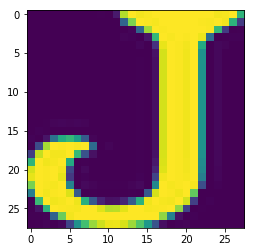

In [10]:
sample_index = 1;
a_sample = train_dataset[sample_index,:,:];
imgplot = plt.imshow(a_sample)

## Save the data
Save the data for later use.

In [11]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


## Train an logistic regression
Train a logistic regression model on this data using 50, 100, 1000 and 5000 training samples using [sklearn.linear_model.LogistricRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression).
### Reference
[Notes of logistic regression](https://github.com/xiangli-chen/home/blob/master/machine-learning/general-supervised-learning.pdf)

In [5]:
# reformulate the data
# data: {array-like, sparse matrix}, shape (n_samples, n_features)
# label: rray-like, shape (n_samples,)

pickle_file = './data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

image_size = 28
def reformat(dataset):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  return dataset

train_X = reformat(train_dataset)
test_X = reformat(test_dataset)

# initialize a logistic regression
# l2 penalty, lbfgs algorithm, multinomial
LR = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                   fit_intercept=True, intercept_scaling=1, class_weight=None, 
                   random_state=None, solver='lbfgs', max_iter=100, 
                   multi_class='multinomial', verbose=0, warm_start=False, n_jobs=1)

num_all_data = train_X.shape[0]
# num_all_data = 100
various_num_training_data = np.array([50, 100, 1000, 5000, num_all_data]);

def various_training_samples(model, various_num_training_data, 
                             train_data, train_labels, test_data, test_labels):
    for num_data in various_num_training_data:
        model.fit(train_data[:num_data,:], train_labels[:num_data])
        print('Number of training data:', num_data, 
              'accuracy:', model.score(test_data, test_labels))

various_training_samples(LR, various_num_training_data, 
                             train_X, train_labels, test_X, test_labels)

Training set (200000, 28, 28) (200000,)
Test set (10000, 28, 28) (10000,)
Number of training data: 50 accuracy: 0.4849
Number of training data: 100 accuracy: 0.7136
Number of training data: 1000 accuracy: 0.8425
Number of training data: 5000 accuracy: 0.8438
Number of training data: 200000 accuracy: 0.8999
